# Weather Dataset

This dataset contains 14 metrics related to weather sampled every 10 minutes from 2009 to 2016 (other versions of the dataset go from 2003 to present). In this notebook the test, training, and validation datasets are named the same for every case so make sure to run the cell for the appropriate dataset before attempting to train a model.

## Imports

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

InteractiveShell.ast_node_interactivity = 'all'
plt.style.use('dark_background')

## Loading and Processing the Dataset

In [2]:
zip_path = tf.keras.utils.get_file(
    extract=True,
    fname='jena_climate_2009_2016.csv.zip',
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)
df = df[5::6] # Subsampling the dataset to hourly from every 10 minutes
print('Dataset Head:')
df.head()
print('Dataset Statistics:')
df.describe()

# Removing erroneous values from the wv and max_wv columns
wv = df['wv (m/s)']
wv[wv == -9999] = 0
max_wv = df['max. wv (m/s)']
max_wv[max_wv == -9999] = 0
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Creating a 2d wind vector feature instead of direction and velocity
wd_rad = df.pop('wd (deg)')*np.pi/180
df['wx'] = wv*np.cos(wd_rad)
df['wy'] = wv*np.sin(wd_rad)
df['max wx'] = max_wv*np.cos(wd_rad)
df['max_wy'] = max_wv*np.sin(wd_rad)

# Creating a time feature for time of day and time of year
day = 24*3600
year = 365.2425*day
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_seconds = date_time.map(pd.Timestamp.timestamp)
df['Day sin'] = np.sin(timestamp_seconds*(2*np.pi)/day)
df['Day cos'] = np.cos(timestamp_seconds*(2*np.pi)/day)
df['Year sin'] = np.sin(timestamp_seconds*(2*np.pi)/year)
df['Year cos'] = np.cos(timestamp_seconds*(2*np.pi)/year)

split = (.7, .2, .1) # The split for the training, validation, and testing datasets, respectively

# Splitting the dataset
n = len(df)
train_df = df[:int(n*split[0])]
validation_df = df[int(n*split[0]):int(n*(split[0]+split[1]))]
test_df = df[int(n*(1-split[2])):]

# Normalizing the datasets
train_mean = train_df.mean()
train_std = train_df.std()
test_df = (test_df-train_mean)/train_std
train_df = (train_df-train_mean)/train_std
validation_df = (validation_df-train_mean)/train_std

print('Final Dataset Head:')
train_df.head()
print('Final Dataset Statistics:')
train_df.describe()

Dataset Head:


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Dataset Statistics:


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000
mean,989.212842,9.450482,283.493086,4.956471,76.009788,13.576576,9.533968,4.042536,6.022560,9.640437,1216.061232,1.702567,2.963041,174.789095
std,8.358886,8.423384,8.504424,6.730081,16.474920,7.739883,4.183658,4.898549,2.655812,4.234862,39.974263,65.447512,75.597657,86.619431
min,913.600000,-22.760000,250.850000,-24.800000,13.880000,0.970000,0.810000,0.000000,0.510000,0.810000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.350000,277.440000,0.240000,65.210000,7.770000,6.220000,0.870000,3.920000,6.290000,1187.470000,0.990000,1.760000,125.300000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.980000,198.100000
75%,994.720000,15.480000,289.530000,10.080000,89.400000,17.610000,12.360000,5.300000,7.800000,12.490000,1242.765000,2.860000,4.740000,234.000000
max,1015.290000,37.280000,311.210000,23.060000,100.000000,63.770000,28.250000,46.010000,18.070000,28.740000,1393.540000,14.010000,23.500000,360.000000


Final Dataset Head:


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wx,wy,max wx,max_wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.366111,1.366069,-0.061052,1.428434
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.707200,1.224794,-0.060029,1.428424
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,1.000100,1.000059,-0.059006,1.428412
23,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,1.224850,0.707179,-0.057983,1.428400
29,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,1.366133,0.366112,-0.056960,1.428388


Final Dataset Statistics:


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wx,wy,max wx,max_wy,Day sin,Day cos,Year sin,Year cos
count,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04
mean,1.807385e-16,-1.714699e-16,9.500357e-16,2.780592e-17,-6.812451e-16,-2.780592e-17,-2.548876e-16,-9.268641e-18,-1.204923e-16,1.853728e-16,-2.326429e-15,-6.951481e-17,-1.622012e-17,-1.506154e-17,-3.939173e-17,-4.999998e-17,3.537290e-17,-3.244024e-17,3.244024e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.045695e+00,-3.682079e+00,-3.707266e+00,-4.216645e+00,-3.746587e+00,-1.609554e+00,-2.030996e+00,-8.298612e-01,-2.022853e+00,-2.031986e+00,-3.846513e+00,-5.321263e+00,-5.048245e+00,-5.972942e+00,-5.410607e+00,-1.414169e+00,-1.414050e+00,-1.502697e+00,-1.382842e+00
25%,-6.093840e-01,-7.069026e-01,-6.939982e-01,-6.697392e-01,-6.581569e-01,-7.505257e-01,-7.786971e-01,-6.575813e-01,-7.762466e-01,-7.761335e-01,-7.116941e-01,-4.375161e-01,-6.242102e-01,-4.814777e-01,-6.182100e-01,-9.999460e-01,-9.998544e-01,-9.856843e-01,-1.010608e+00
50%,5.467421e-02,9.450477e-03,1.318575e-02,5.168967e-02,1.989686e-01,-2.228923e-01,-1.561120e-01,-3.835939e-01,-1.548152e-01,-1.540757e-01,-7.847992e-02,-1.597386e-02,7.420737e-02,-4.660022e-02,8.077215e-02,7.679677e-05,1.024151e-04,7.747715e-02,-1.470386e-02
75%,6.548575e-01,7.200265e-01,7.123465e-01,7.530390e-01,8.150841e-01,5.334687e-01,6.684569e-01,2.681639e-01,6.650251e-01,6.651626e-01,6.442168e-01,4.738166e-01,5.582518e-01,5.441849e-01,6.019162e-01,1.000100e+00,1.000059e+00,9.874267e-01,1.001990e+00
max,2.913378e+00,3.066661e+00,3.041354e+00,2.647686e+00,1.455361e+00,5.846190e+00,4.489514e+00,7.842254e+00,4.550843e+00,4.524268e+00,4.310438e+00,4.391051e+00,5.203526e+00,4.117034e+00,5.730397e+00,1.414323e+00,1.414255e+00,1.351906e+00,1.428505e+00


In the above cell we first remove erroneous values for the wind velocity (since a separate wind direction column is present, the wind velocity should always be positive and a wind velocity of -9999 m/s is obviously incorrect). We then replace the wind direction and velocity columns with two columns representing the x and y components of a wind vector. We also replace the date time column with four columns representing the sin and cosine components of the time of day and year (the time of the day/year is represented as an angle due to their periodicity and both the sine and cosine components are necessary to resolve the ambiguity present in either one alone). We then split into testing, training, and validation sets. Finally, we normalize the data by subtracting out the training set mean and rescaling by the training set standard deviation. The training set values are used for this since the model shouldn't have any access to the validation or testing data.

## Helper Functions

In [104]:
AUTOTUNE = tf.data.AUTOTUNE

def compile_and_train_model(model, train_ds, validation_ds, learning_rate=0.001, patience=3):
    '''
    Takes a model and training and validation datasets as input and returns the trained model and its training history
    '''
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        mode='min',
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
        optimizer=tf.keras.optimizers.Adam(learning_rate),
    )
    history = model.fit(
        train_ds,
        callbacks=[early_stopping_callback],
        epochs=100,
        validation_data=validation_ds
    )
    return model, history

def split_window(window, input_seq_length, pred_seq_length, input_col_indices, pred_col_indices):
    '''
    Helper function to index into the right input and prediction columns since Tensorflow doesn't support 
    non-consecutive indexing (i.e. indexing with a list/array/tensor)
    '''
    input_data = [window[:, :input_seq_length, i:i+1] for i in input_col_indices]
    pred_data = [window[:, -pred_seq_length:, i:i+1] for i in pred_col_indices]
    return tf.concat(input_data, 2), tf.concat(pred_data, 2)

def generate_ds(df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size):
    '''
    df is expected to be a dataframe of data
    input_seq_length is expected to be an integer and determines how many time steps will be present in the
    input to the model
    pred_seq_length is expected to be an integer and determines how many timesteps will be present in the 
    expected output of the model
    input_columns is expected to be a list of column names of df or the string 'all' and determines what 
    columns of df will be used as inputs to the model
    pred_columns is expected to be a list of column names of df or the string 'all' and determines what 
    columns of df will be used as expected outputs of the model
    batch_size is expected to be an integer and determines the size of batches present in the dataset

    The output dataset will have be tuples of tensors with shape (batch_size, seq_length, num_columns)
    where seq_length and num_columns are as specified for the input and output respectively in the tuple
    '''
    window_length = input_seq_length+pred_seq_length

    col_to_ind = {name:i for i, name in enumerate(df.columns)}
    if input_columns == 'all':
        input_col_indices = [col_to_ind[name] for name in df.columns]
    else:
        input_col_indices = [col_to_ind[name] for name in input_columns]
    if pred_columns == 'all':
        pred_col_indices = [col_to_ind[name] for name in df.columns]
    else:
        pred_col_indices = [col_to_ind[name] for name in pred_columns]

    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        df.to_numpy(),
        None,
        window_length,
        batch_size=batch_size,
        shuffle=True
    )
    # ds = ds.unbatch()
    # ds = ds.batch(batch_size, drop_remainder=True, num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda window: split_window(window, input_seq_length, pred_seq_length, input_col_indices, pred_col_indices), num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

def plot_training_metrics(history):
    '''
    Takes a history object generated along with model training and plots
    selected training metrics.
    '''
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('MAE')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.suptitle('Model Training')
    plt.legend()
    plt.show()

def save_best_model(model, test_ds, filename, save_traces=False):
    '''
    Compares the performance of a saved model stored at filename with the provided model on
    the provided test dataset. If the provided model performs better than the saved model
    the provided model is saved to filename, overwriting the previously saved model. If
    no saved model is present at filename then the provided model is saved to filename
    '''
    try:
        saved_model = tf.keras.models.load_model(filename)
    except:
        saved_model = None

    if saved_model:
        print('Saved Model Evaluation:')
        saved_model_metrics = saved_model.evaluate(test_ds, return_dict=True)
        print('New Model Evaluation:')
        new_model_metrics = model.evaluate(test_ds, return_dict=True)
        if new_model_metrics['loss'] < saved_model_metrics['loss']:
            model.save(filename, save_traces=save_traces)
    else:
        print('New Model Evaluation:')
        new_model_metrics = model.evaluate(test_ds)
        model.save(filename, save_traces=save_traces)

## Predicting a Single Output Value from a Single Feature

### Creating the Dataset

In [228]:
batch_size = 64
input_columns = ['T (degC)']
input_seq_length = 24 # One day
pred_columns = ['T (degC)']
pred_seq_length = 1 # One hour

test_ds = generate_ds(test_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)
train_ds = generate_ds(train_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)
validation_ds = generate_ds(validation_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)

### Creating a Baseline Model and Measuring its Performance

In [229]:
class Baseline(tf.keras.Model):
    def call(self, inputs):
        return inputs[:,-1:, :]

baseline = Baseline()
baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)
loss, mae = baseline.evaluate(test_ds)

110/110 [==============================] - 1s 5ms/step - loss: 0.0142 - mean_absolute_error: 0.0854


### Creating and Training a Model

In [7]:
# Best Model
# model = tf.keras.Sequential([
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dense(1)
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1)
])
model, history = compile_and_train_model(model, train_ds, validation_ds)

Epoch 1/100
767/767 [==============================] - 11s 8ms/step - loss: 0.0272 - mean_absolute_error: 0.1085 - val_loss: 0.0082 - val_mean_absolute_error: 0.0635
Epoch 2/100
767/767 [==============================] - 6s 8ms/step - loss: 0.0080 - mean_absolute_error: 0.0630 - val_loss: 0.0073 - val_mean_absolute_error: 0.0591
Epoch 3/100
767/767 [==============================] - 6s 8ms/step - loss: 0.0077 - mean_absolute_error: 0.0609 - val_loss: 0.0075 - val_mean_absolute_error: 0.0610
Epoch 4/100
767/767 [==============================] - 6s 8ms/step - loss: 0.0076 - mean_absolute_error: 0.0603 - val_loss: 0.0071 - val_mean_absolute_error: 0.0578
Epoch 5/100
767/767 [==============================] - 6s 8ms/step - loss: 0.0075 - mean_absolute_error: 0.0599 - val_loss: 0.0073 - val_mean_absolute_error: 0.0598
Epoch 6/100
767/767 [==============================] - 6s 8ms/step - loss: 0.0074 - mean_absolute_error: 0.0595 - val_loss: 0.0071 - val_mean_absolute_error: 0.0585
Epoch 7/1

### Plotting Training Metrics and Saving the Best Model

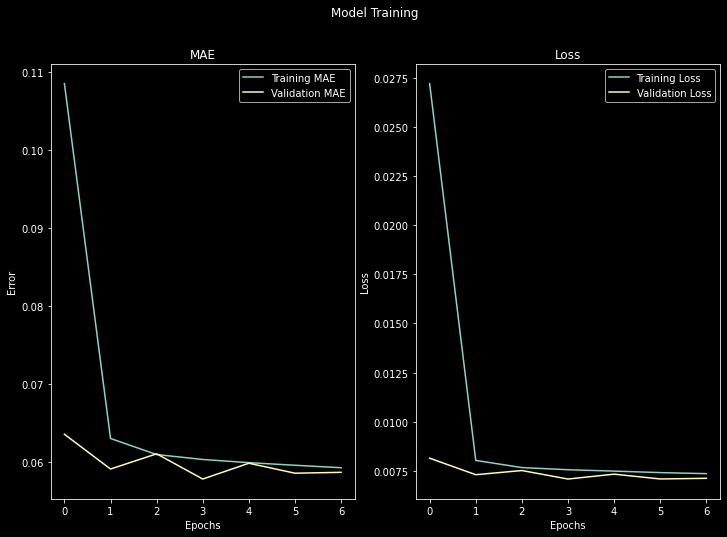

Saved Model Evaluation:
110/110 [==============================] - 1s 3ms/step - loss: 0.0066 - mean_absolute_error: 0.0562
New Model Evaluation:
110/110 [==============================] - 0s 3ms/step - loss: 0.0069 - mean_absolute_error: 0.0579


In [8]:
plot_training_metrics(history)
save_best_model(model, test_ds, 'models\\SingleStep\\SingleInputSinglePrediction')

The best model reassuringly does do better than the baseline

## Predicting a Single Output Given Multiple Inputs

### Creating the Dataset

In [9]:
batch_size = 64
input_columns = 'all'
input_seq_length = 24 # One day
pred_columns = ['T (degC)']
pred_seq_length = 1 # One hour

test_ds = generate_ds(test_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)
train_ds = generate_ds(train_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)
validation_ds = generate_ds(validation_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)

### Creating and Training a Model

In [10]:
# Best Model
# model = tf.keras.Sequential([
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
#     tf.keras.layers.Dense(1)
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(1)
])
model, history = compile_and_train_model(model, train_ds, validation_ds)

Epoch 1/100
767/767 [==============================] - 10s 9ms/step - loss: 0.0187 - mean_absolute_error: 0.0884 - val_loss: 0.0069 - val_mean_absolute_error: 0.0592
Epoch 2/100
767/767 [==============================] - 7s 9ms/step - loss: 0.0070 - mean_absolute_error: 0.0597 - val_loss: 0.0062 - val_mean_absolute_error: 0.0558
Epoch 3/100
767/767 [==============================] - 7s 9ms/step - loss: 0.0066 - mean_absolute_error: 0.0574 - val_loss: 0.0060 - val_mean_absolute_error: 0.0542
Epoch 4/100
767/767 [==============================] - 7s 9ms/step - loss: 0.0064 - mean_absolute_error: 0.0566 - val_loss: 0.0059 - val_mean_absolute_error: 0.0536
Epoch 5/100
767/767 [==============================] - 7s 9ms/step - loss: 0.0062 - mean_absolute_error: 0.0556 - val_loss: 0.0058 - val_mean_absolute_error: 0.0525
Epoch 6/100
767/767 [==============================] - 7s 9ms/step - loss: 0.0061 - mean_absolute_error: 0.0549 - val_loss: 0.0058 - val_mean_absolute_error: 0.0532
Epoch 7/1

### Plotting Training Metrics and Saving the Best Model

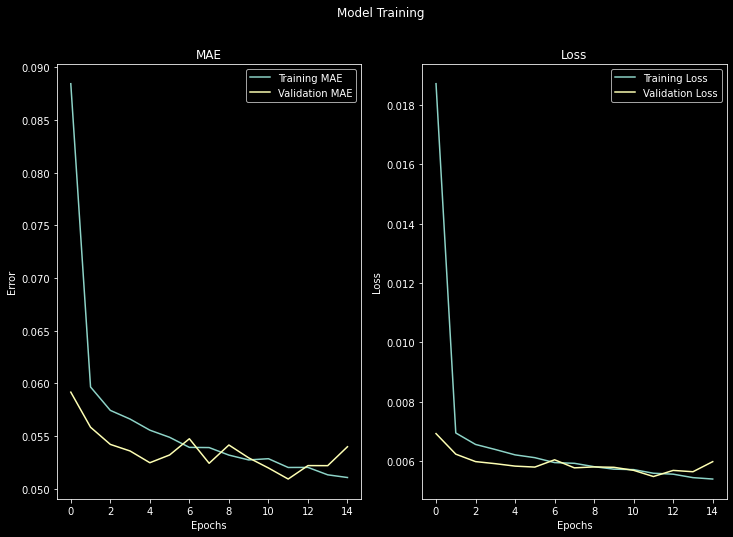

Saved Model Evaluation:
110/110 [==============================] - 1s 3ms/step - loss: 0.0055 - mean_absolute_error: 0.0518
New Model Evaluation:
110/110 [==============================] - 0s 4ms/step - loss: 0.0055 - mean_absolute_error: 0.0517
INFO:tensorflow:Assets written to: models\SingleStep\MultiInputSinglePrediction\assets


In [11]:
plot_training_metrics(history)
save_best_model(model, test_ds, 'models\\SingleStep\\MultiInputSinglePrediction')

This model does only slightly better than the model with just the temperature information, indicating that the majority of the predictive power is present in the temperature data, but some additional accuracy can be gained through including the other weather information as features.

## Predicting Multiple Outputs Given Multiple Inputs

### Generating the Dataset

In [234]:
batch_size = 64
input_columns = 'all'
input_seq_length = 24 # One day
pred_columns = 'all'
# pred_columns = ['p (mbar)', 'T (degC)']
pred_seq_length = 1 # One hour

test_ds = generate_ds(test_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)
train_ds = generate_ds(train_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)
validation_ds = generate_ds(validation_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)

### Creating a Naive Baseline and Testing its Performance

In [232]:
baseline = Baseline()
baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)
loss, mae = baseline.evaluate(test_ds)

110/110 [==============================] - 1s 5ms/step - loss: 0.0903 - mean_absolute_error: 0.1638


### Creating and Training a Model

In [237]:
# Best Model
# model = tf.keras.Sequential([
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dense(len(train_df.columns)),
#     tf.keras.layers.Reshape((1, -1))
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(len(train_df.columns)),
    tf.keras.layers.Reshape((1, -1))
])
model, history = compile_and_train_model(model, train_ds, validation_ds)

Epoch 1/100
767/767 [==============================] - 11s 10ms/step - loss: 0.1506 - mean_absolute_error: 0.2412 - val_loss: 0.0736 - val_mean_absolute_error: 0.1549
Epoch 2/100
767/767 [==============================] - 7s 9ms/step - loss: 0.0697 - mean_absolute_error: 0.1428 - val_loss: 0.0674 - val_mean_absolute_error: 0.1372
Epoch 3/100
767/767 [==============================] - 7s 9ms/step - loss: 0.0664 - mean_absolute_error: 0.1332 - val_loss: 0.0651 - val_mean_absolute_error: 0.1308
Epoch 4/100
767/767 [==============================] - 6s 8ms/step - loss: 0.0652 - mean_absolute_error: 0.1294 - val_loss: 0.0648 - val_mean_absolute_error: 0.1293
Epoch 5/100
767/767 [==============================] - 6s 8ms/step - loss: 0.0646 - mean_absolute_error: 0.1275 - val_loss: 0.0642 - val_mean_absolute_error: 0.1270
Epoch 6/100
767/767 [==============================] - 6s 8ms/step - loss: 0.0640 - mean_absolute_error: 0.1260 - val_loss: 0.0634 - val_mean_absolute_error: 0.1253
Epoch 7/

### Plotting Training Metrics and Saving the Best Model

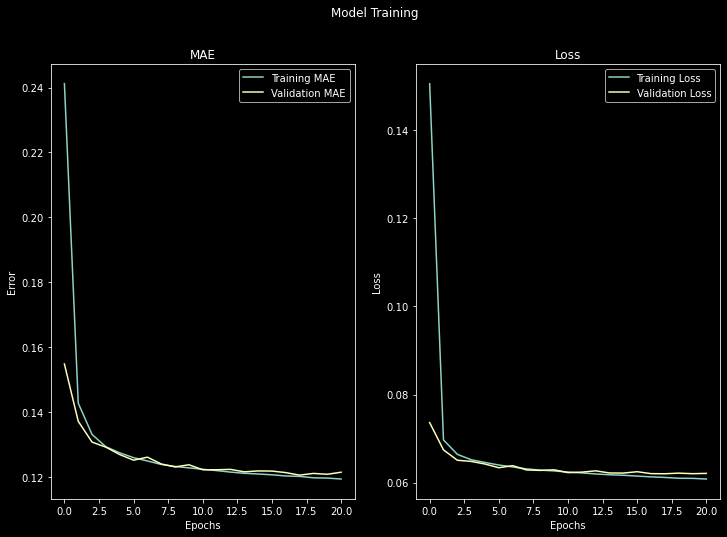

Saved Model Evaluation:
110/110 [==============================] - 1s 3ms/step - loss: 0.0610 - mean_absolute_error: 0.1205
New Model Evaluation:
110/110 [==============================] - 0s 3ms/step - loss: 0.0623 - mean_absolute_error: 0.1225


In [238]:
plot_training_metrics(history)
save_best_model(model, test_ds, 'models\\SingleStep\\MultiInputMultiOutput')

## Testing a One Week Window

### Single Input Single Prediction

#### Generating the Dataset

In [5]:
batch_size = 64
input_columns = ['T (degC)']
input_seq_length = 24*7 # One week
pred_columns = ['T (degC)']
pred_seq_length = 1 # One hour

test_ds = generate_ds(test_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)
train_ds = generate_ds(train_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)
validation_ds = generate_ds(validation_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)

#### Creating and Training a Model

In [6]:
# Best Model
# model = tf.keras.Sequential([
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dense(1)
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1)
])
model, history = compile_and_train_model(model, train_ds, validation_ds, patience=3)

Epoch 1/100
764/764 [==============================] - 23s 23ms/step - loss: 0.0284 - mean_absolute_error: 0.1090 - val_loss: 0.0084 - val_mean_absolute_error: 0.0652
Epoch 2/100
764/764 [==============================] - 17s 23ms/step - loss: 0.0080 - mean_absolute_error: 0.0633 - val_loss: 0.0072 - val_mean_absolute_error: 0.0591
Epoch 3/100
764/764 [==============================] - 18s 23ms/step - loss: 0.0075 - mean_absolute_error: 0.0605 - val_loss: 0.0073 - val_mean_absolute_error: 0.0597
Epoch 4/100
764/764 [==============================] - 17s 23ms/step - loss: 0.0073 - mean_absolute_error: 0.0594 - val_loss: 0.0073 - val_mean_absolute_error: 0.0602
Epoch 5/100
764/764 [==============================] - 17s 22ms/step - loss: 0.0072 - mean_absolute_error: 0.0589 - val_loss: 0.0067 - val_mean_absolute_error: 0.0557
Epoch 6/100
764/764 [==============================] - 17s 22ms/step - loss: 0.0072 - mean_absolute_error: 0.0589 - val_loss: 0.0071 - val_mean_absolute_error: 0.058

#### Plotting Training Metrics and Saving the Best Model

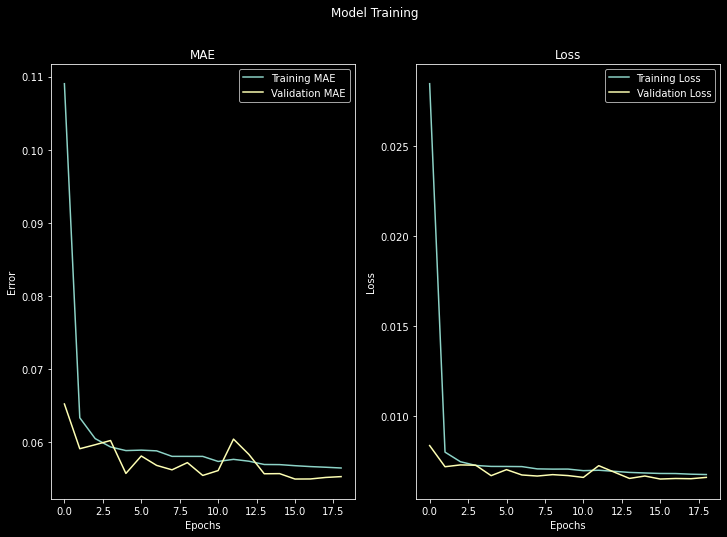

INFO:tensorflow:Assets written to: models\Week_Single_Input_Single_Prediction\assets


In [7]:
plot_training_metrics(history)
save_best_model(model, test_ds, 'models\\SingleStep\\WeekSingleInputSinglePrediction')

### Multiple Input Single Prediction

#### Generating the Dataset

In [8]:
batch_size = 64
input_columns = 'all'
input_seq_length = 24*7 # One week
pred_columns = ['T (degC)']
pred_seq_length = 1 # One hour

test_ds = generate_ds(test_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)
train_ds = generate_ds(train_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)
validation_ds = generate_ds(validation_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)

#### Creating and Training a Model

In [9]:
# Best Model
# model = tf.keras.Sequential([
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dense(1)
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1)
])
model, history = compile_and_train_model(model, train_ds, validation_ds)

Epoch 1/100
764/764 [==============================] - 22s 24ms/step - loss: 0.0201 - mean_absolute_error: 0.0940 - val_loss: 0.0083 - val_mean_absolute_error: 0.0676
Epoch 2/100
764/764 [==============================] - 17s 22ms/step - loss: 0.0070 - mean_absolute_error: 0.0600 - val_loss: 0.0065 - val_mean_absolute_error: 0.0581
Epoch 3/100
764/764 [==============================] - 17s 23ms/step - loss: 0.0065 - mean_absolute_error: 0.0572 - val_loss: 0.0063 - val_mean_absolute_error: 0.0566
Epoch 4/100
764/764 [==============================] - 17s 22ms/step - loss: 0.0062 - mean_absolute_error: 0.0555 - val_loss: 0.0061 - val_mean_absolute_error: 0.0552
Epoch 5/100
764/764 [==============================] - 17s 22ms/step - loss: 0.0062 - mean_absolute_error: 0.0552 - val_loss: 0.0062 - val_mean_absolute_error: 0.0562
Epoch 6/100
764/764 [==============================] - 17s 22ms/step - loss: 0.0060 - mean_absolute_error: 0.0541 - val_loss: 0.0061 - val_mean_absolute_error: 0.055

#### Plotting Training Metrics and Saving the Best Model

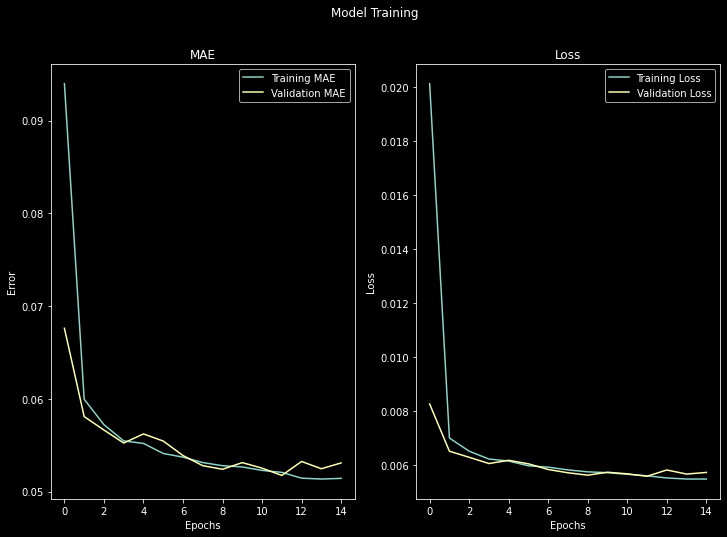

INFO:tensorflow:Assets written to: models\Week_Multiple_Input_Single_Prediction\assets


In [10]:
plot_training_metrics(history)
save_best_model(model, test_ds, 'models\\SingleStep\\WeekMultipleInputSinglePrediction')

## Predicting a Sequence All at Once

### Generating the Dataset

In [239]:
batch_size = 64
input_columns = 'all'
input_seq_length = 24*7 # One week
pred_columns = ['T (degC)']
pred_seq_length = 24 # One day

if pred_columns == 'all':
    num_pred_features = len(train_df.columns)
else:
    num_pred_features = len(pred_columns)

test_ds = generate_ds(test_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)
train_ds = generate_ds(train_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)
validation_ds = generate_ds(validation_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)

### Creating and Training a Model

In [250]:
# Best Model
# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(64),
#     tf.keras.layers.Dense(num_pred_features*pred_seq_length),
#     tf.keras.layers.Reshape((pred_seq_length, num_pred_features))
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(num_pred_features*pred_seq_length),
    tf.keras.layers.Reshape((pred_seq_length, num_pred_features))
])
model, history = compile_and_train_model(model, train_ds, validation_ds)

Epoch 1/100
764/764 [==============================] - 21s 24ms/step - loss: 0.1754 - mean_absolute_error: 0.3033 - val_loss: 0.0944 - val_mean_absolute_error: 0.2366
Epoch 2/100
764/764 [==============================] - 17s 22ms/step - loss: 0.0828 - mean_absolute_error: 0.2218 - val_loss: 0.0858 - val_mean_absolute_error: 0.2240
Epoch 3/100
764/764 [==============================] - 17s 23ms/step - loss: 0.0754 - mean_absolute_error: 0.2097 - val_loss: 0.0822 - val_mean_absolute_error: 0.2180
Epoch 4/100
764/764 [==============================] - 17s 22ms/step - loss: 0.0714 - mean_absolute_error: 0.2030 - val_loss: 0.0792 - val_mean_absolute_error: 0.2134
Epoch 5/100
764/764 [==============================] - 17s 22ms/step - loss: 0.0689 - mean_absolute_error: 0.1988 - val_loss: 0.0786 - val_mean_absolute_error: 0.2121
Epoch 6/100
764/764 [==============================] - 17s 23ms/step - loss: 0.0674 - mean_absolute_error: 0.1961 - val_loss: 0.0787 - val_mean_absolute_error: 0.211

### Plotting Training Metrics and Saving the Best Model

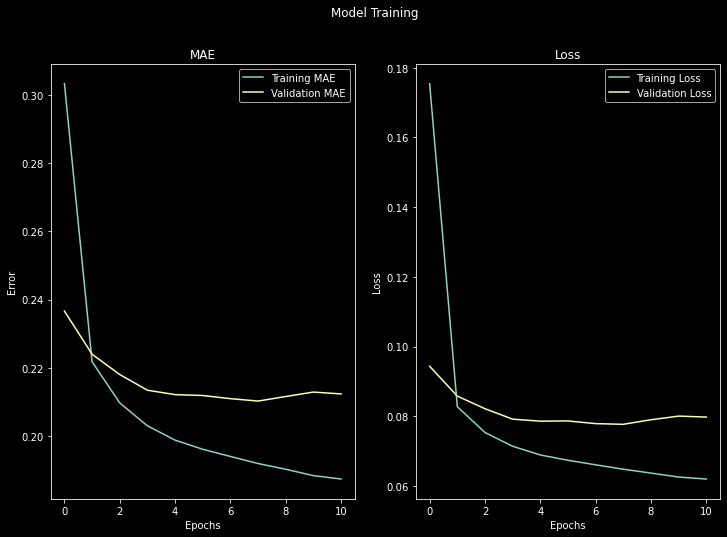

Saved Model Evaluation:
107/107 [==============================] - 1s 6ms/step - loss: 0.0612 - mean_absolute_error: 0.1874
New Model Evaluation:
107/107 [==============================] - 1s 11ms/step - loss: 0.0651 - mean_absolute_error: 0.1949


In [251]:
plot_training_metrics(history)
save_best_model(model, test_ds, 'models\\Sequence\\MultiInput')

## Predicting a Sequence Through Autoregression

### Generating a Dataset

Note that for autoregression, the input features (input_columns) must match the predicted features (pred_columns)

In [77]:
batch_size = 64
input_columns = 'all'
input_seq_length = 24*7 # One week
pred_columns = 'all'
pred_seq_length = 24 # One day

if pred_columns == 'all':
    num_pred_features = len(train_df.columns)
else:
    num_pred_features = len(pred_columns)

test_ds = generate_ds(test_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)
train_ds = generate_ds(train_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)
validation_ds = generate_ds(validation_df, input_seq_length, pred_seq_length, input_columns, pred_columns, batch_size)

### Creating and Training a Model

In [89]:
class AutoRegressionLSTM(tf.keras.Model):
    # This model learns separate weight matrices for warmup and call to enable proper saving/loading
    def __init__(self, units, num_pred_features, pred_seq_length):
        super().__init__()
        self.num_pred_features = num_pred_features
        self.pred_seq_length = pred_seq_length
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(self.units)
        self.lstm_rnn = tf.keras.layers.LSTM(self.units, return_state=True)
        self.dense = tf.keras.layers.Dense(self.num_pred_features)

    def call(self, inputs, training=None):
        preds = []
        pred, state = self.warmup(inputs)
        preds.append(pred)
        for _ in range(1, self.pred_seq_length):
            x = pred
            x, state = self.lstm_cell(x, states=state, training=training)
            pred = self.dense(x)
            preds.append(pred)
        preds = tf.stack(preds)
        preds = tf.transpose(preds, [1, 0, 2])
        return preds

    def get_config(self):
        config = super().get_config()
        config.update({'units':self.units, 'num_pred_features':self.num_pred_features, 'pred_seq_length':self.pred_seq_length})
        return config

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        pred = self.dense(x)
        return pred, state

In [106]:
# Best Model
# model = AutoRegressionLSTM(32, num_pred_features, pred_seq_length)

model = AutoRegressionLSTM(32, num_pred_features, pred_seq_length)
model, history = compile_and_train_model(model, train_ds, validation_ds)

Epoch 1/100
764/764 [==============================] - 27s 31ms/step - loss: 0.3621 - mean_absolute_error: 0.4229 - val_loss: 0.2567 - val_mean_absolute_error: 0.3425
Epoch 2/100
764/764 [==============================] - 23s 30ms/step - loss: 0.2342 - mean_absolute_error: 0.3221 - val_loss: 0.2338 - val_mean_absolute_error: 0.3160
Epoch 3/100
764/764 [==============================] - 23s 30ms/step - loss: 0.2190 - mean_absolute_error: 0.3044 - val_loss: 0.2261 - val_mean_absolute_error: 0.3051
Epoch 4/100
764/764 [==============================] - 23s 30ms/step - loss: 0.2113 - mean_absolute_error: 0.2959 - val_loss: 0.2220 - val_mean_absolute_error: 0.3010
Epoch 5/100
764/764 [==============================] - 23s 30ms/step - loss: 0.2062 - mean_absolute_error: 0.2903 - val_loss: 0.2211 - val_mean_absolute_error: 0.2994
Epoch 6/100
764/764 [==============================] - 24s 31ms/step - loss: 0.2025 - mean_absolute_error: 0.2867 - val_loss: 0.2191 - val_mean_absolute_error: 0.295

### Plotting Training Metrics and Saving the Best Model

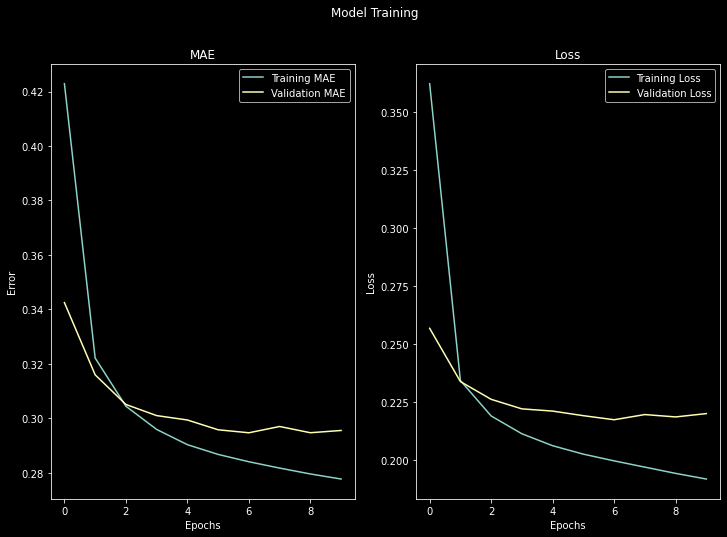

Saved Model Evaluation:
107/107 [==============================] - 5s 44ms/step - loss: 0.2069 - mean_absolute_error: 0.2881
New Model Evaluation:
107/107 [==============================] - 1s 12ms/step - loss: 0.2054 - mean_absolute_error: 0.2872


INFO:tensorflow:Assets written to: models\Sequence\AutoRegressionLSTM\assets


INFO:tensorflow:Assets written to: models\Sequence\AutoRegressionLSTM\assets


In [107]:
plot_training_metrics(history)
save_best_model(model, test_ds, 'models\\Sequence\\AutoRegressionLSTM', save_traces=True)